Problems
- the premute the tensor can be a problematic. because in the official implementation there was no need for the permutation.
- the implementation of conv1d in pytorch and tensorflow is different. so my pytorch version can be wrong as i didnot understand few things.
- masking was not done.

In [1]:
import sys
import os

# Step 1: Get current directory 
current_directory = os.getcwd()        # '/home/bear-b/users/jshi008/IvyProjects/FIDLA/train_WaLeF_models'
print(current_directory)

# Step 2: Get path of parent directory (one level up)
parent_directory = os.path.dirname(current_directory)    # '/home/bear-b/users/jshi008/IvyProjects/FIDLA'
print(parent_directory)
# Step 3: Append parent directory to sys.path
sys.path.append(parent_directory)

f:\OUT\DL\Implementing FIDLAR\train_WaLeF_models
f:\OUT\DL\Implementing FIDLAR


In [2]:
import torch
from torch import nn
import torch.utils.data as data_utils
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR

from IPython import display


from baselines.cnn import CNN
from preprocess.BaselinePrerocess import baseline_process

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Preprocess

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


In [6]:
train_X_mask, val_X_mask, test_X_mask, train_ws_y, val_ws_y, test_ws_y = torch.from_numpy(train_X_mask), torch.from_numpy(val_X_mask), torch.from_numpy(test_X_mask), torch.from_numpy(train_ws_y), torch.from_numpy(val_ws_y), torch.from_numpy(test_ws_y)

In [7]:
train_X_mask = train_X_mask.permute(0, 2, 1)
val_X_mask = val_X_mask.permute(0, 2, 1)
test_X_mask = test_X_mask.permute(0, 2, 1)
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

torch.Size([77069, 16, 96]) torch.Size([9634, 16, 96]) torch.Size([19268, 16, 96]) torch.Size([77069, 96]) torch.Size([9634, 96]) torch.Size([19268, 96])


In [8]:
batch_size = 512
train_loader = data_utils.DataLoader(data_utils.TensorDataset(train_X_mask, train_ws_y), batch_size=batch_size, shuffle=True)
val_loader = data_utils.DataLoader(data_utils.TensorDataset(val_X_mask, val_ws_y), batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(data_utils.TensorDataset(test_X_mask, test_ws_y), batch_size=batch_size, shuffle=True)

# Model

In [3]:
# ===== model parameters ======
cnn_unit1 = 64
cnn_unit2 = 32
cnn_unit3 = 16
dropout = 0.1
kernel_size = 2
pool_size=2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512
input_shape = (96, 16)#train_X_mask.shape[1:]

In [4]:
x = torch.rand([1, 16, 96])
cnn = CNN(
            cnn_unit1=cnn_unit1,
            cnn_unit2=cnn_unit2,
            cnn_unit3=cnn_unit3,
            dropout=dropout,
            kernel_size=kernel_size,
            pool_size=pool_size,
)

c:\Users\User\miniconda3\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
import torch
from torch.nn.parameter import UninitializedParameter

def count_parameters(model):
    dummy_input = torch.randn(1, 16, 96)
    model.forward(dummy_input)
    
    return sum(p.numel() for p in model.parameters() if p.requires_grad and not isinstance(p, UninitializedParameter))

total_params = count_parameters(cnn)
print(total_params)

25808


# Training

In [17]:
model = cnn.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, )
scheduler = ExponentialLR(optimizer, gamma=decay_rate,
                        #   last_epoch=-1
                          )
from torchmetrics.regression import MeanAbsoluteError
criterion = torch.nn.MSELoss()
MAE = MeanAbsoluteError().to(device)

train_losses = []
val_losses = []
num_epochs = 30

Epoch: 30 - Train Loss: 3.635e-04 - Val Loss: 1.502e-03 - Train MAE: 0.01286 - Val MAE: 0.03131


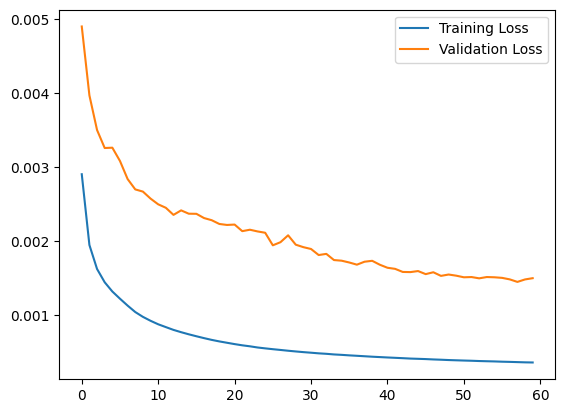

In [19]:
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_mae = 0
    
    for batch in train_loader:
        inp, out = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        m_out = model(inp)
        loss = criterion(m_out, out)
        mae_train = MAE(m_out, out)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        total_train_loss += loss.item()
        total_train_mae += mae_train.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_mae = total_train_mae / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    total_val_loss = 0
    total_val_mae = 0
    with torch.no_grad():
        for batch in val_loader:
            inp, out = batch[0].to(device), batch[1].to(device)
            m_out = model(inp)
            loss = criterion(m_out, out)
            mae_val = MAE(m_out, out)
            total_val_loss += loss.item()
            total_val_mae += mae_val.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_mae = total_val_mae / len(val_loader)
    val_losses.append(avg_val_loss)
    
    display.clear_output(wait=True)
    print(f"Epoch: {epoch+1} - Train Loss: {avg_train_loss:.3e} - Val Loss: {avg_val_loss:.3e} - Train MAE: {avg_train_mae:.5f} - Val MAE: {avg_val_mae:.5f}")
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.show(block=False)

    if len(val_losses) > 1:
        if val_losses[-1] < val_losses[-2]:
            torch.save(model.state_dict(), '../saved_model/WaLeF_cnn.pth')

# Epoch 2233/3000
# 151/151 - 1s - loss: 1.2726e-04 - mae: 0.0072 - val_loss: 6.2366e-04 - val_mae: 0.0182